### Example: Download and use GeoTOP netcdf data from OPeNDAP server
Read GeoTOP for a specific bounding box (xmin, ymin, xmax, ymax) from the OPeNDAP server. For this example we will only use the 'strat' (i.e. stratigraphy) and 'lithok' (i.e. lithology) data variables. The example will show how to plot simple maps or cross-sections and how to make some selections of specific units or lithologies.

First import the required packages for the example.

In [2]:
import contextily as ctx # for background maps
import geopandas as gpd
from matplotlib import pyplot as plt
from shapely.geometry import box, LineString

## local imports for GeoTOP examples
from atmod.bro_models import (
    GeoTop,
    Lithology,
    StratGeoTop
)

We will download GeoTOP for an area of 5x5 kilometers nearby Utrecht and we will define a line that we can use to select the data for a cross-section. The bounding box and cross-section line are below. We will first plot a map of the area where we download GeoTOP and the location of the cross-section we make.

In [4]:
xmin, xmax = 127_000, 132_000
ymin, ymax = 448_000, 453_000

bbox = (xmin, ymin, xmax, ymax)
cross_section_line = LineString([[xmin+500, ymin+500], [xmax-500, ymax-500]])

gdf_area = gpd.GeoDataFrame(geometry=[box(*bbox)], crs=28992)


## plot the area and cross-section line
fig, ax = plt.subplots()
ax.plot(*cross_section_line.xy, c='k')
gdf_area.plot(ax=ax, facecolor='none', edgecolor='r')
gdf_area.buffer(3000).plot(ax=ax, facecolor='none', edgecolor='none')
ctx.add_basemap(ax=ax, crs=gdf_area.crs)
ax.set_xlabel('Easting [m]')
ax.set_ylabel('Northing [m]')


: 

Next, we will download GeoTOP directly from the OPeNDAP server and create a GeoTop class instance. The GeoTop is an implementation of the VoxelModel class which holds the spatial attributes and contains selection methods. Printing the GeoTop class instance shows the available data variables, the corresponding dimensions and spatial and vertical resolution of the model. We will also show that the model bounds are the same as the requested bounding box.

In [3]:
opendap_url = r'https://dinodata.nl/opendap/GeoTOP/geotop.nc'
geotop = GeoTop.from_opendap(opendap_url, bbox=bbox, data_vars=['strat', 'lithok'])

print(geotop)
print(f'\nmodel bounds: {geotop.bounds}')

NameError: name 'bbox' is not defined

The GeoTop class instance is basically a reference to Xarray DataArrays so any Xarray/Numpy method can be applied to the attributes of the class attributes. For example, we can easily select specific depths and plot the stratigraphic and lithologic composition.

Text(0.5, 1.0, 'Lithology -0.5 m NAP')

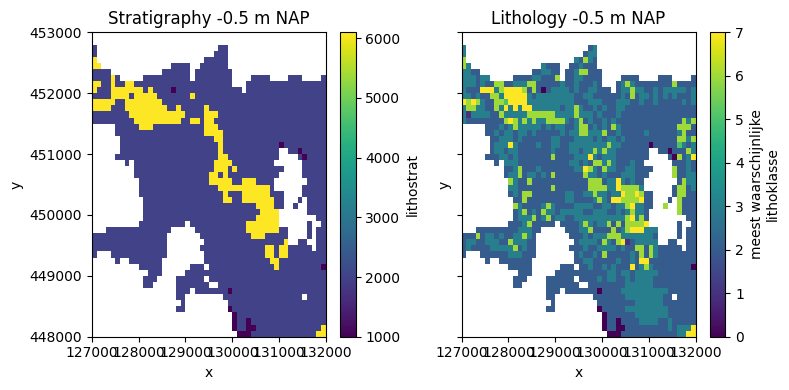

In [60]:
fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(8, 4), tight_layout=True)
geotop['strat'].sel(z=-0.5).plot(ax=ax[0])
geotop['lithok'].sel(z=-0.5).plot(ax=ax[1])
ax[0].set_title('Stratigraphy -0.5 m NAP')
ax[1].set_title('Lithology -0.5 m NAP')

The 'strat' and 'lithok' DataArrays contain float values that indicate the stratigraphy, conform the Dutch lithostratigraphic [nomenclature](https://www.dinoloket.nl/stratigrafische-nomenclator), and the lithology conform groupings of lithoclasses. Atmod contains classes to help with easy selections of specific units and lithologies or groups of both. Below shows an example where the stratigraphy map is grouped to show the location of channel-belt units and the lithology map is grouped show the sand lithologies. 

Text(0.5, 1.0, 'Is sand at -0.5 m NAP')

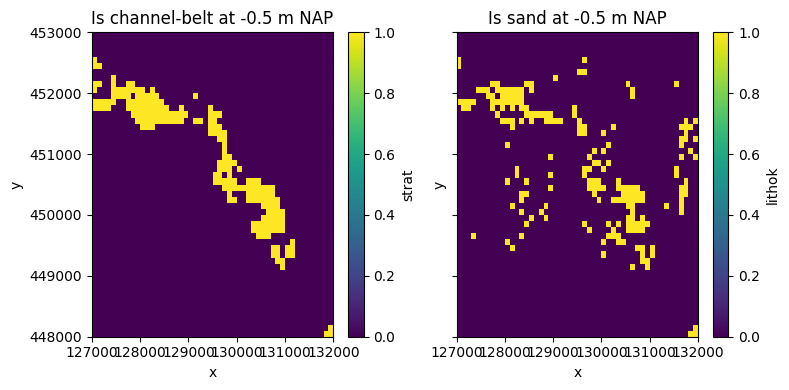

In [65]:
strat_select = geotop['strat'].sel(z=-0.5)
litho_select = geotop['lithok'].sel(z=-0.5)

sand = [Lithology.fine_sand, Lithology.medium_sand, Lithology.coarse_sand]

is_channel_map = strat_select.isin(StratGeoTop.channel_belts.values)
is_sand_map = litho_select.isin(sand)

fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(8, 4), tight_layout=True)
is_channel_map.plot(ax=ax[0])
is_sand_map.plot(ax=ax[1])
ax[0].set_title('Is channel-belt at -0.5 m NAP')
ax[1].set_title('Is sand at -0.5 m NAP')

We can also relatively easily create cross-sections using our defined LineString from the start of the example. To do this, we define sample points with a specific spacing along the LineString and use their coordinates to select a cross section dataset.